In [1]:
from pymongo import MongoClient
import pymongo
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as sig
from IPython.parallel import Client
import sys
import numbapro

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
client = MongoClient()
db = client.VentDyssynchrony_db
breath_data = db.BreathData_collection
patient_data = db.PatientData_collection
RN_data = db.RNData_collection
patient_data = db.PatientData_collection

In [3]:
#ipclient = Client()
#print (ipclient.ids)
#ipview = ipclient[:]
#ipview = ipclient.load_balanced_view()

In [4]:
unpack_col = ''
def unpack(breath, unpack_col = unpack_col):
        for col in unpack_col:      
            key_names = set()
            keys = set()
            key = ''

            if ('RT' in col) or ('RN' in col) or ('Lab' in col):
                keys = breath[col].apply(lambda x: set(list(x[0].keys()))).tolist()

                for items in keys:
                    key_names.update(items)

                for key in key_names:
                    breath[col +':'+ key] = breath[col].apply(lambda x: x[0][key] if key in x[0] else np.nan)
            else:       
                try:
                    keys = breath[col].apply(lambda x: set(x.keys()) if isinstance(x, dict) else set())
                except:
                    print('first', keys, col, sys.exc_info()[0])

                try:
                    for items in keys:
                        key_names.update(items)
                except:
                    print('mid', sys.exc_info()[0])
                    print(keys)

                try:
                    for key in key_names:
                        breath[col +':'+ key] = breath[col].apply(lambda x: x[key] if (isinstance(x, dict) and (key in x)) else np.nan)
                    breath.drop(col, inplace=True, axis=1)
                except:
                    print(sys.exc_info()[0])
                    print('last', key, keys, key_names)

        return breath

In [5]:
breaths = breath_data.find({},
                           {'_id':1, 'patientID':1 ,'breath_number':1, 'file_name':1,'start_time':1, 'characteristics':1, 'characteristics:ds_vol':1, 'vent_settings':1, 'analysis':1})
breath_df = pd.DataFrame(list(breaths))
del breaths
breath_df = unpack(breath_df, unpack_col = ['characteristics', 'vent_settings', 'analysis'])
breath_df.drop(['characteristics:min_flow', 'characteristics:min_flow', 'characteristics:max_pressure', 'characteristics:min_pressure'], inplace=True, axis=1)
try:
    breath_df.drop(['analysis:validation'], axis=1, inplace=True)
except:
    pass

In [6]:
breath_df.columns

Index(['_id', 'breath_number', 'characteristics:ds_vol', 'file_name', 'patientID', 'start_time', 'characteristics:max_flow', 'characteristics:exp_time', 'characteristics:breath_time', 'characteristics:peak_pressure', 'characteristics:end_insp_vol', 'characteristics:min_vol', 'characteristics:peak_insp_flow', 'characteristics:max_vol', 'characteristics:min_exp_flow', 'characteristics:insp_time', 'vent_settings:set_rate', 'vent_settings:trigger', 'vent_settings:ti', 'vent_settings:ramp', 'vent_settings:p_mean', 'vent_settings:distance', 'vent_settings:PEEP', 'vent_settings:leak', 'vent_settings:vent_mode', 'vent_settings:reference_doc', 'vent_settings:te', 'vent_settings:set_VT', 'vent_settings:p_peak', 'vent_settings:compliance', 'vent_settings:FiO2', 'vent_settings:file_name', 'vent_settings:ie', 'vent_settings:load_errors', 'vent_settings:p_plat', 'analysis:ds', 'analysis:pl', 'analysis:pds', 'analysis:pvt', 'analysis:ie', 'analysis:fl'], dtype='object')

In [7]:
breath_df[['characteristics:ds_vol', 'characteristics:max_vol', 'characteristics:peak_pressure']].describe()

,characteristics:ds_vol,characteristics:max_vol,characteristics:peak_pressure
count,37824.000000,1299170.000000,1299170.000000
mean,611.542605,415.638125,23.339006
std,389.134689,119.642726,6.517910
min,50.000000,-1075.000000,-11.300000
25%,432.500000,367.500000,18.500000
50%,555.000000,407.500000,23.500000
75%,687.500000,460.000000,28.300000
max,8887.500000,5117.500000,65.300000


In [8]:
breath_df[breath_df['analysis:ds']==True][['characteristics:ds_vol', 'characteristics:max_vol']].describe()

,characteristics:ds_vol,characteristics:max_vol
count,37824.000000,37880.000000
mean,611.542605,401.271977
std,389.134689,223.319772
min,50.000000,55.000000
25%,432.500000,295.000000
50%,555.000000,380.000000
75%,687.500000,465.000000
max,8887.500000,5100.000000


In [9]:
breath_df['analysis:pds'].value_counts()

True    37776
dtype: int64

In [10]:
def find_post_ds(row):       
    breath = breath_data.find_one({'file_name': row['file_name'], 'breath_number':row['breath_number']+1}, {'_id':1, 'characteristics.max_vol':1})
    
    if isinstance(breath, type(None)):
        print(breath, row['_id'], row['file_name'], row['breath_number'])
        return np.nan
    else:

        max_vol = breath['characteristics']['max_vol']
        ds_vol = max_vol + row['characteristics:end_insp_vol']
        #try:   
            #breath_data.update_one({'_id':row['_id']}, {'$set':{'characteristics.ds_vol':ds_vol}})
        #except:
        #    print('vol_update',sys.exc_info()[0])
        try:
            breath_data.update_one({'file_name': row['file_name'], 'breath_number':row['breath_number']+1}, {'$set':{'analysis.pds':True}})
        except pymongo.errors.WriteError as e:
            print(e)
            print(breath_data.find_one({'file_name': row['file_name'], 'breath_number':row['breath_number']+1}, {'analysis.pds':True}))
            print('pds_update', sys.exc_info()[0])
        return ds_vol

#breath_df['characteristics:ds_vol'] = breath_df[(breath_df['analysis:ds'] == True)].apply(find_post_ds, axis=1)        
#breath_df['characteristics:ds_vol'] = breath_df[(breath_df['analysis:ds'] == True) & (pd.isnull(breath_df['characteristics:ds_vol']))].apply(find_post_ds, axis=1)

In [11]:
breath_df.loc[(breath_df['analysis:pds'] != True), 'analysis:pds'] = False

In [12]:
@numbapro.vectorize(['float64(boolean, float64, float64)'])
def set_max_vol(analysis_ds, char_ds_vol, char_max_vol):
    if analysis_ds is True and not isinstance(char_ds_vol, type(None)):
        return char_ds_vol
    else:
        return char_max_vol

breath_df['characteristics:max_vol'] = set_max_vol(breath_df['analysis:ds'].values, breath_df['characteristics:ds_vol'].values, breath_df['characteristics:max_vol'].values)

In [13]:
#breath_df['characteristics:max_vol'] = breath_df.apply(lambda x: x['characteristics:ds_vol'] if (x['analysis:ds'] == True) and not (isinstance(x['characteristics:ds_vol'], type(None))) else x['characteristics:max_vol'], axis=1)

In [14]:
patient = patient_data.find({},{'_id':1, 'intubation_date':1,'pbw':1, 'Start_End_NMB':1})
patient_df = pd.DataFrame(list(patient))

In [15]:
breath_df['pbw'] = np.nan
for row, items in patient_df.iterrows():
    breath_df.loc[breath_df['patientID'] == items['_id'],'pbw'] = items['pbw']
    
breath_df['characteristics:norm_max_vol'] = breath_df['characteristics:max_vol']/breath_df['pbw']
breath_df['vent_settings:norm_VT'] = breath_df['vent_settings:set_VT']/breath_df['pbw']

In [16]:
breath_df[['characteristics:norm_max_vol', 'vent_settings:norm_VT']].describe()

,characteristics:norm_max_vol,vent_settings:norm_VT
count,1266871.000000,978782.000000
mean,6.582933,6.565208
std,2.073985,0.897353
min,-6.004720,4.947954
25%,5.604356,5.978965
50%,6.538368,6.414985
75%,7.537080,7.019394
max,114.502785,9.178305


In [17]:
breath_df['analysis:normal'] = False
#breath_df.loc[((breath_df['analysis:pl']==True) | (breath_df['analysis:fl']==True) | (breath_df['analysis:pds']!=True) | (breath_df['analysis:pvt']==True) | (breath_df['analysis:ds']==True) | (breath_df['analysis:ie']==True)),'analysis:normal'] = False
breath_df.loc[((breath_df['analysis:pl']!=True) & (breath_df['analysis:fl']!=True) & (breath_df['analysis:pds']!=True) & (breath_df['analysis:pvt']!=True) & (breath_df['analysis:ds']!=True) & (breath_df['analysis:ie']!=True)),'analysis:normal'] = True

In [18]:
breath_df['analysis:normal'].value_counts()

True     766920
False    532250
dtype: int64

In [19]:
breath_df['vent_settings:vent_mode'].value_counts()

APVCMV     996418
PCMV       152585
SPONT      132637
APRV        12423
Standby        12
dtype: int64

In [20]:
breath_df['nmb'] = False
for row, items in patient_df.iterrows():
    if not isinstance(items['Start_End_NMB'], float):
        times_couples = items['Start_End_NMB'].strip('[](').split('),')
        
        for time_sets in times_couples:
            start_stop = time_sets.strip(' ()').split(', ')
            start = pd.to_datetime(start_stop[0])
            stop = pd.to_datetime(start_stop[1])
            
            breath_df.loc[(breath_df['patientID'] == items['_id']) & (start <= breath_df['start_time']) & (breath_df['start_time'] <= stop),'nmb'] = True

In [21]:
breath_df['nmb'].value_counts()

False    1034253
True      264917
dtype: int64

In [22]:
#['characteristics:min_vol', 'characteristics:exp_time', 'characteristics:max_vol', 'characteristics:peak_pressure', 'vent_settings:set_VT', 'vent_settings:FiO2', 
#                   'vent_settings:p_plat','vent_settings:set_rate']

for breath_types in ['analysis:pl', 'analysis:pds', 'analysis:ie', 'analysis:fl', 'analysis:pvt', 'analysis:ds', 'analysis:normal']:
    for charac in ['characteristics:max_vol', 'characteristics:norm_max_vol', 'characteristics:peak_pressure', 'vent_settings:norm_VT', 'vent_settings:set_VT', 'vent_settings:FiO2', 
                   'vent_settings:set_rate']:
            gp = breath_df.groupby(breath_types)
            print('mean: ', charac, gp[charac].apply(np.mean))
            print('sd: ', charac, gp[charac].apply(np.std))
            print('ttest:',charac, sp.stats.ttest_ind(gp[charac].get_group(True), gp[charac].get_group(False)))
            print('\n')

mean:  characteristics:max_vol analysis:pl
False    414.621364
True     464.796472
Name: characteristics:max_vol, dtype: float64
sd:  characteristics:max_vol analysis:pl
False    120.387386
True     198.477193
Name: characteristics:max_vol, dtype: float64
ttest: characteristics:max_vol (nan, nan)


mean:  characteristics:norm_max_vol analysis:pl
False    6.497482
True     7.086414
Name: characteristics:norm_max_vol, dtype: float64
sd:  characteristics:norm_max_vol analysis:pl
False    1.897616
True     2.851678
Name: characteristics:norm_max_vol, dtype: float64
ttest: characteristics:norm_max_vol (nan, nan)


mean:  characteristics:peak_pressure analysis:pl
False    23.827989
True     20.391599
Name: characteristics:peak_pressure, dtype: float64
sd:  characteristics:peak_pressure analysis:pl
False    6.438807
True     6.207440
Name: characteristics:peak_pressure, dtype: float64
ttest: characteristics:peak_pressure (-213.59238836839251, 0.0)


mean:  vent_settings:norm_VT analysis:pl
Fa

In [23]:
for items in ['analysis:ds', 'analysis:pds', 'analysis:fl',  'analysis:pl', 'analysis:pvt', 'analysis:ie']:
    breath_df[items.split(':')[1]+'_norm'] = np.nan
    breath_df.loc[(breath_df['analysis:ds'] == True), items.split(':')[1]+'_norm'] = True
    breath_df.loc[(breath_df['analysis:normal'] == True), items.split(':')[1]+'_norm'] = False

In [24]:
summary_df = breath_df[['patientID', 'start_time', 'breath_number', 'vent_settings:vent_mode', 'characteristics:breath_time', 'characteristics:peak_pressure', 'characteristics:end_insp_vol', 'characteristics:norm_max_vol', 'characteristics:max_vol','vent_settings:FiO2', 'vent_settings:PEEP', 'vent_settings:set_VT', 'vent_settings:norm_VT', 'vent_settings:set_rate', 'analysis:ds', 'analysis:pds', 'analysis:fl',  'analysis:pl', 'analysis:pvt', 'analysis:ie','analysis:normal','ds_norm','pds_norm','fl_norm','pl_norm', 'pvt_norm','ie_norm', 'pbw', 'nmb']]
summary_df.replace([True, False, type(None)], [1,0,0])

summary_df['intubation_time'] = np.nan
for row, items in patient_df.iterrows():
    summary_df.loc[(summary_df['patientID'] == items['_id']), 'intubation_time'] = items['intubation_date']
    
summary_df['intubation_time'] = pd.to_datetime(summary_df['intubation_time'])

E:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda\lib\site-packages\pandas\core\indexing.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
E:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

In [25]:
summary_df.loc[(summary_df['intubation_time'] + pd.to_timedelta(48, unit='H') <= summary_df['start_time']), 'less_48_h'] = True
summary_df.loc[(summary_df['intubation_time'] + pd.to_timedelta(48, unit='H') > summary_df['start_time']), 'less_48_h'] = False

E:\Anaconda\lib\site-packages\pandas\core\indexing.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [26]:
summary_df.to_csv('E:\Research_Data\All_Paw_Vol_Results.csv')

In [32]:
time_df = breath_df.set_index('start_time')
time_df = time_df.replace([True, False], [1,0])
time_df = time_df[time_df['nmb'] == False]
time_df = time_df[['patientID', 'analysis:ds', 'analysis:pds', 'analysis:fl', 'analysis:pl',  'analysis:ie', 'analysis:pvt', 'analysis:normal', 'vent_settings:FiO2', 'nmb']]
time_df['vent_settings:FiO2'] = time_df['vent_settings:FiO2']/100
time_df['analysis.total'] = 1
time_df = time_df.groupby('patientID')
time_df.head(3)

,patientID,analysis:ds,analysis:pds,analysis:fl,analysis:pl,analysis:ie,analysis:pvt,analysis:normal,vent_settings:FiO2,nmb,analysis.total
start_time,,,,,,,,,,,
2014-04-21 13:01:28,P100,False,0,False,False,True,False,False,0.4,False,1
2014-04-22 18:38:06,P101,True,0,False,False,False,False,False,0.5,False,1
2014-04-21 13:01:29,P100,False,0,False,False,True,False,False,0.4,False,1
2014-04-21 13:01:33,P100,False,0,True,False,True,True,False,0.4,False,1
2014-05-10 21:51:10,P102,True,0,False,False,False,False,False,0.6,False,1
2014-05-10 16:57:02,P102,False,0,False,False,True,False,False,0.7,False,1
2014-04-22 18:38:06,P101,False,1,False,False,False,False,False,0.5,False,1
2014-04-22 18:38:09,P101,True,0,True,True,False,False,False,0.5,False,1
2015-04-19 19:54:17,P122,False,0,False,False,False,False,True,0.6,False,1


E:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=395356.0, right=395356.0
  'left=%s, right=%s') % (left, right))
E:\Anaconda\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


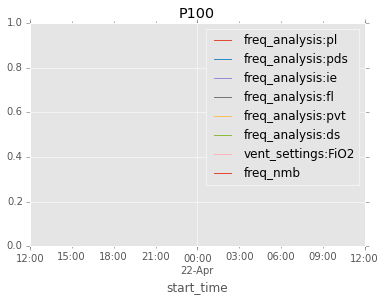

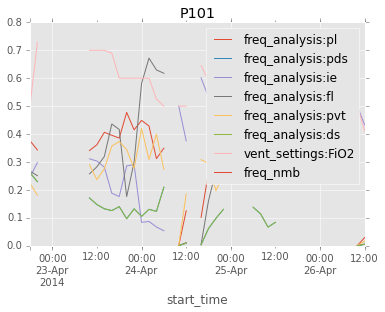

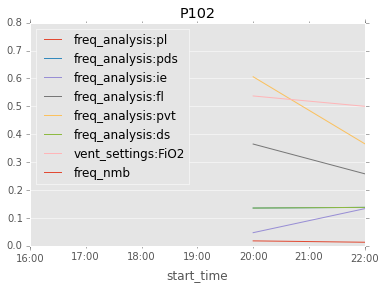

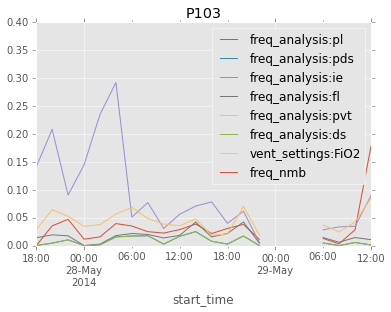

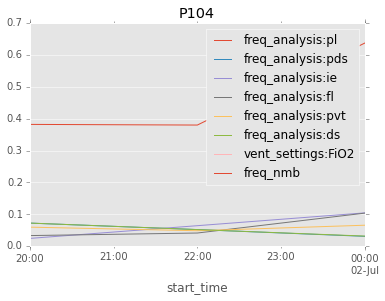

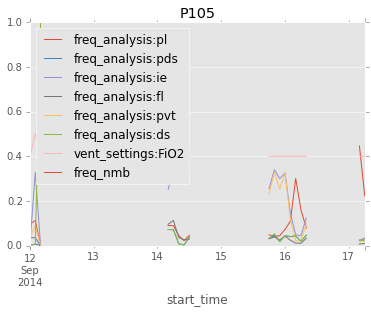

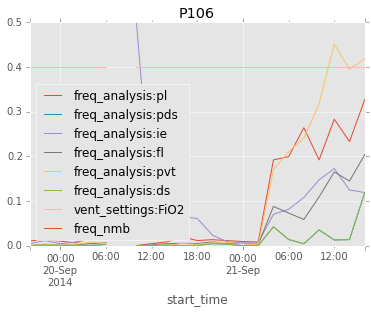

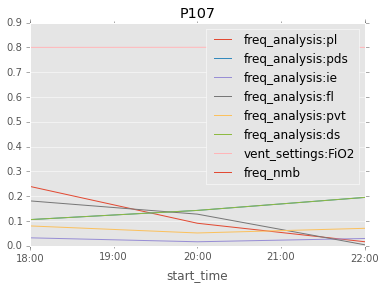

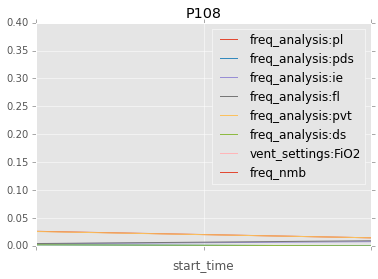

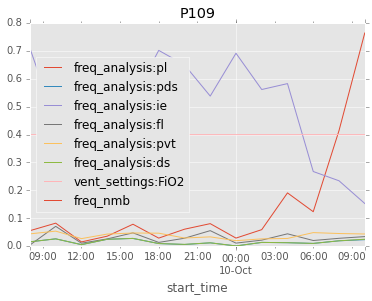

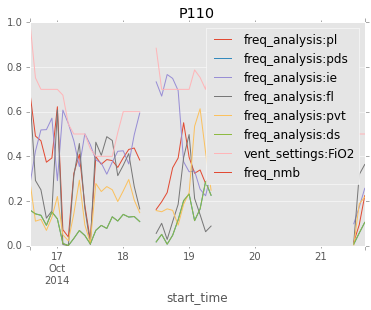

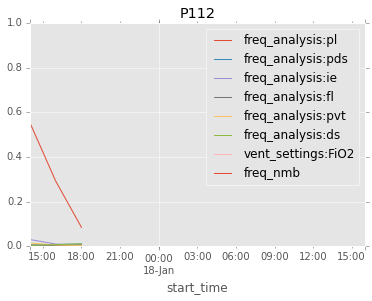

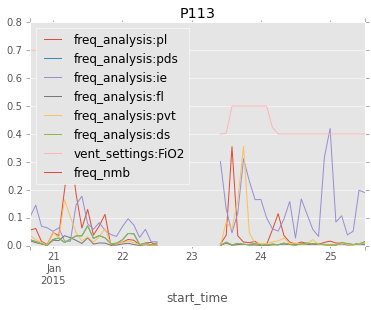

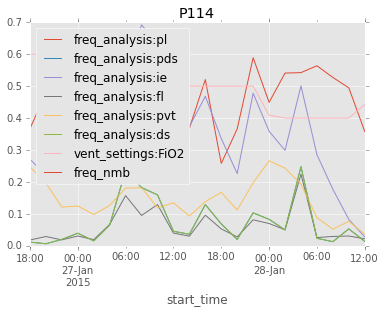

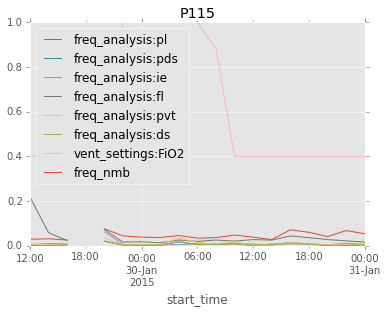

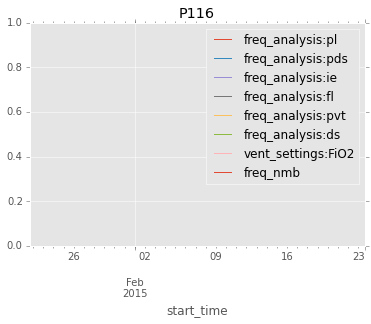

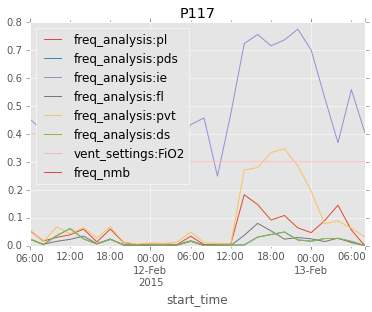

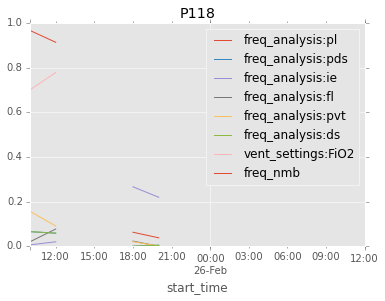

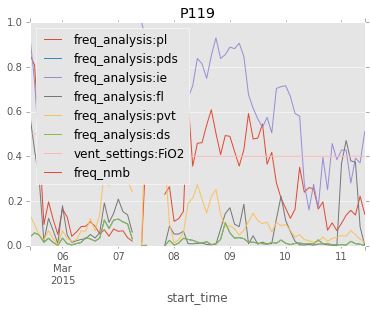

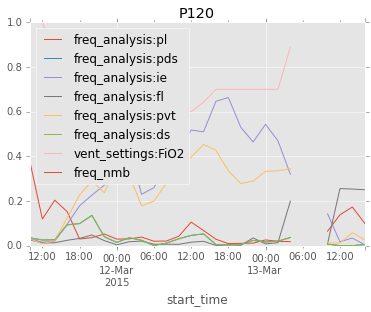

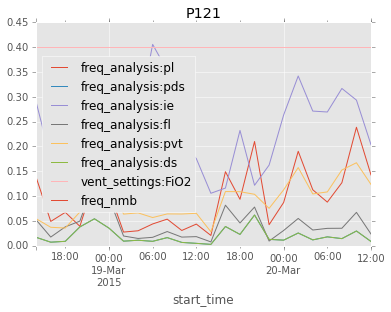

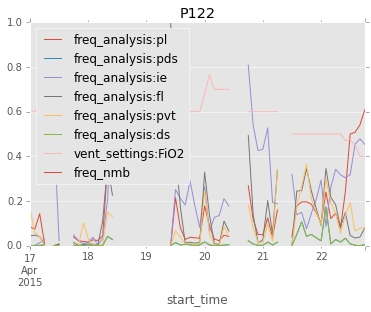

In [33]:
resampled_df = pd.DataFrame()

for name, group in time_df:
    hour_df = group.resample('2H', how={'analysis.total': sum, 'analysis:normal':sum, 'analysis:pl':sum, 'analysis:pds':sum, 'analysis:ie':sum, 'analysis:fl':sum, 'analysis:pvt':sum, 'analysis:ds':sum, 'vent_settings:FiO2':np.mean, 'nmb':sum}, closed='left', axis=0)
    for items in ['analysis:pl', 'analysis:pds', 'analysis:ie', 'analysis:normal','analysis:fl', 'analysis:pvt', 'analysis:ds', 'nmb']:
        hour_df['freq_'+items] = hour_df[items]/hour_df['analysis.total']
    hour_df['patientID'] = name
    hour_df.plot(y=['freq_analysis:pl', 'freq_analysis:pds', 'freq_analysis:ie','freq_analysis:fl', 'freq_analysis:pvt', 'freq_analysis:ds', 'vent_settings:FiO2', 'freq_nmb'])
    plt.title(name)
    if resampled_df.shape[0] == 0:
        resampled_df = hour_df
    else:
        resampled_df = resampled_df.append(hour_df)

In [34]:
resampled_df.head()

,analysis:pds,vent_settings:FiO2,analysis:pl,analysis:fl,analysis:normal,analysis:ie,analysis.total,analysis:ds,nmb,analysis:pvt,freq_analysis:pl,freq_analysis:pds,freq_analysis:ie,freq_analysis:normal,freq_analysis:fl,freq_analysis:pvt,freq_analysis:ds,freq_nmb,patientID
start_time,,,,,,,,,,,,,,,,,,,
2014-04-21 12:00:00,0,0.4,0,1,0,5,5,0,0,2,0.000000,0,1.000000,0.000000,0.200,0.400000,0.000000,0,P100
2014-04-21 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P100
2014-04-21 16:00:00,0,0.4,19,27,1,68,72,1,0,16,0.263889,0,0.944444,0.013889,0.375,0.222222,0.013889,0,P100
2014-04-21 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P100
2014-04-21 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P100


In [35]:
RN_data_results = RN_data.find()
RN_df = pd.DataFrame(list(RN_data_results))
RN_df = unpack(RN_df, unpack_col=['RN_entry'])
RN_df = RN_df[['entry_time', 'patientID', 'RN_entry:FiO2', 'RN_entry:PEEP', 'RN_entry:TOF', 'RN_entry:CPOT Tot', 'RN_entry:CPOT Vent', 'RN_entry:SpO2','RN_entry:RASS']]
RN_df['entry_time'] = pd.to_datetime(RN_df['entry_time'])
RN_df.set_index('entry_time', inplace=True)
RN_df = RN_df.groupby('patientID')

In [36]:
resampled_RN_df = pd.DataFrame()

for name, group in RN_df:
    hour_df = group.resample('2H', how=np.mean)
    hour_df['patientID'] = name
    if resampled_RN_df.shape[0] == 0:
        resampled_RN_df = hour_df
    else:
        resampled_RN_df = resampled_RN_df.append(hour_df)

In [37]:
resampled_RN_df.describe()

,RN_entry:FiO2,RN_entry:PEEP,RN_entry:TOF,RN_entry:CPOT Tot,RN_entry:CPOT Vent,RN_entry:SpO2,RN_entry:RASS
count,930.000000,489.000000,93.000000,663.000000,630.000000,2789.000000,1174.000000
mean,51.772401,7.320211,1.956989,1.157164,0.237899,95.343668,-1.242516
std,15.892474,3.075868,1.536965,1.743344,0.481755,3.396613,1.795854
min,30.000000,2.500000,0.000000,0.000000,0.000000,53.500000,-5.000000
25%,40.000000,5.000000,0.000000,0.000000,0.000000,94.000000,-2.000000
50%,40.000000,5.000000,2.000000,0.000000,0.000000,96.000000,-1.000000
75%,60.000000,10.000000,4.000000,2.000000,0.000000,97.500000,0.000000
max,100.000000,17.000000,4.000000,8.000000,2.000000,100.000000,3.000000


In [38]:
resampled_RN_df.head()

,RN_entry:FiO2,RN_entry:PEEP,RN_entry:TOF,RN_entry:CPOT Tot,RN_entry:CPOT Vent,RN_entry:SpO2,RN_entry:RASS,patientID
entry_time,,,,,,,,
2014-04-21 02:00:00,40,NaN,NaN,NaN,NaN,96.200000,NaN,P100
2014-04-21 04:00:00,40,NaN,NaN,NaN,NaN,97.400000,2,P100
2014-04-21 06:00:00,40,NaN,NaN,4.5,1.000000,99.857143,2,P100
2014-04-21 08:00:00,40,NaN,NaN,0.0,0.000000,97.333333,-2,P100
2014-04-21 10:00:00,NaN,NaN,NaN,3.0,0.333333,97.666667,2,P100


In [39]:
resampled_RN_df.reset_index(inplace=True)
resampled_RN_df.rename(columns={'entry_time':'start_time'}, inplace=True)
resampled_RN_df.set_index(['patientID', 'start_time'], inplace=True)
resampled_df.reset_index(inplace=True)
resampled_df.set_index(['patientID', 'start_time'], inplace=True)

total_df = resampled_df.merge(resampled_RN_df, left_index=True, right_index=True)

In [40]:
total_df['RN_entry:RASS'] = total_df['RN_entry:RASS'].apply(np.around)
total_df['RN_entry:RASS'].value_counts()

-2    71
-1    69
-3    50
-5    41
 0    41
-4    30
 1    18
 2    12
 3     1
dtype: int64

In [41]:
RASS = total_df.reset_index()
RASS.dropna(axis=0, how='any', subset=['RN_entry:RASS'], inplace=True)          
RASS_df = RASS.groupby('RN_entry:RASS').agg(np.mean)

In [42]:
RASS_df.head(10)

,analysis:pds,vent_settings:FiO2,analysis:pl,analysis:fl,analysis:normal,analysis:ie,analysis.total,analysis:ds,nmb,analysis:pvt,...,freq_analysis:fl,freq_analysis:pvt,freq_analysis:ds,freq_nmb,RN_entry:FiO2,RN_entry:PEEP,RN_entry:TOF,RN_entry:CPOT Tot,RN_entry:CPOT Vent,RN_entry:SpO2
RN_entry:RASS,,,,,,,,,,,,,,,,,,,,,
-5,2.250000,0.720934,132.333333,93.250000,1434.583333,57.666667,1747.666667,2.333333,0,59.000000,...,0.053362,0.024485,0.001723,0,69.380952,12.629630,1.85,0.053571,0.053571,93.887669
-4,150.923077,0.584709,300.692308,218.884615,1290.153846,740.000000,2637.576923,151.000000,0,563.807692,...,0.107045,0.215863,0.050870,0,59.885057,8.739130,4.00,0.370370,0.296296,95.714444
-3,16.131579,0.459434,128.631579,71.526316,1951.842105,428.342105,2565.921053,16.263158,0,129.421053,...,0.031776,0.051449,0.006915,0,46.022727,8.241379,4.00,0.401709,0.145299,96.323952
-2,97.160714,0.500251,465.892857,223.750000,1112.017857,713.767857,2321.821429,97.714286,0,293.089286,...,0.105503,0.138217,0.040240,0,46.716418,6.940000,NaN,0.647059,0.156863,96.295994
-1,114.859649,0.477622,486.456140,278.263158,888.842105,801.263158,2326.385965,115.070175,0,372.298246,...,0.116175,0.160888,0.044703,0,46.458333,7.287879,4.00,0.950929,0.143728,96.105602
0,73.464286,0.479932,615.357143,114.035714,1029.000000,576.107143,2201.178571,73.535714,0,172.892857,...,0.059055,0.116054,0.037380,0,44.032258,6.923077,NaN,1.416667,0.352941,95.846167
1,52.733333,0.416756,319.666667,79.666667,1085.133333,748.266667,2085.400000,52.866667,0,169.400000,...,0.070968,0.124534,0.030369,0,40.000000,5.150000,NaN,2.616667,0.816667,97.106746
2,52.666667,0.444444,607.888889,95.555556,1899.111111,903.666667,3302.222222,52.777778,0,139.222222,...,0.034130,0.049257,0.014952,0,40.000000,5.000000,NaN,3.585714,0.900000,94.994444
3,98.000000,0.400000,81.000000,42.000000,1214.000000,1291.000000,2742.000000,98.000000,0,184.000000,...,0.015317,0.067104,0.035740,0,NaN,NaN,NaN,NaN,NaN,98.500000


In [43]:
RASS.to_csv('E:\Research_Data\RASS_Results_no_NMB.csv')